# Optimization

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils_v1a import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils_v1a import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from testCasesDNN import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 1 - Gradient Descent

Implement the gradient descent update rule. The  gradient descent rule is, for $l = 1, ..., L$: 
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{1}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{2}$$

In [6]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads['db' + str(l+1)]
        
    return parameters

In [7]:
parameters, grads, learning_rate = update_parameters_with_gd_test_case()

parameters = update_parameters_with_gd(parameters, grads, learning_rate)
print("W1 =\n" + str(parameters["W1"]))
print("b1 =\n" + str(parameters["b1"]))
print("W2 =\n" + str(parameters["W2"]))
print("b2 =\n" + str(parameters["b2"]))

W1 =
[[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 =
[[ 1.74604067]
 [-0.75184921]]
W2 =
[[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 =
[[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]


- **(Batch) Gradient Descent**:

``` python
X = data_input
Y = labels
parameters = initialize_parameters(layers_dims)
for i in range(0, num_iterations):
    # Forward propagation
    a, caches = forward_propagation(X, parameters)
    # Compute cost.
    cost += compute_cost(a, Y)
    # Backward propagation.
    grads = backward_propagation(a, caches, parameters)
    # Update parameters.
    parameters = update_parameters(parameters, grads)
        
```

- **Stochastic Gradient Descent**:

```python
X = data_input
Y = labels
parameters = initialize_parameters(layers_dims)
for i in range(0, num_iterations):
    for j in range(0, m):
        # Forward propagation
        a, caches = forward_propagation(X[:,j], parameters)
        # Compute cost
        cost += compute_cost(a, Y[:,j])
        # Backward propagation
        grads = backward_propagation(a, caches, parameters)
        # Update parameters.
        parameters = update_parameters(parameters, grads)
```

<img src="deep-neural-network-images/kiank_sgd.png" style="width:750px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **SGD vs GD**<br> "+" denotes a minimum of the cost. SGD leads to many oscillations to reach convergence. But each step is a lot faster to compute for SGD than for GD, as it uses only one training example (vs. the whole batch for GD). </center></caption>
    
<img src="deep-neural-network-images/kiank_minibatch.png" style="width:750px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u>: <font color='purple'>  **SGD vs Mini-Batch GD**<br> "+" denotes a minimum of the cost. Using mini-batches in your optimization algorithm often leads to faster optimization. </center></caption>    

## 2 - Mini-Batch Gradient descent

- **Shuffle**: Create a shuffled version of the training set (X, Y) as shown below. Each column of X and Y represents a training example. Note that the random shuffling is done synchronously between X and Y. Such that after the shuffling the $i^{th}$ column of X is the example corresponding to the $i^{th}$ label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches. 

<img src="deep-neural-network-images/kiank_shuffle.png" style="width:550px;height:300px;">

- **Partition**: Partition the shuffled (X, Y) into mini-batches of size `mini_batch_size` (here 64). Note that the number of training examples is not always divisible by `mini_batch_size`. The last mini batch might be smaller, but you don't need to worry about this. When the final mini-batch is smaller than the full `mini_batch_size`, it will look like this: 

<img src="deep-neural-network-images/kiank_partition.png" style="width:550px;height:300px;">

In [9]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [10]:
X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess, Y_assess, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]


## 3 - Momentum

<img src="deep-neural-network-images/opt_momentum.png" style="width:400px;height:250px;">
<caption><center> <u><font color='purple'>**Figure 3**</u><font color='purple'>: The red arrows shows the direction taken by one step of mini-batch gradient descent with momentum. The blue points show the direction of the gradient (with respect to the current mini-batch) on each step. Rather than just following the gradient, we let the gradient influence $v$ and then take a step in the direction of $v$.<br> <font color='black'> </center>

In [11]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
        
    return v

In [12]:
parameters = initialize_velocity_test_case()

v = initialize_velocity(parameters)
print("v[\"dW1\"] =\n" + str(v["dW1"]))
print("v[\"db1\"] =\n" + str(v["db1"]))
print("v[\"dW2\"] =\n" + str(v["dW2"]))
print("v[\"db2\"] =\n" + str(v["db2"]))

v["dW1"] =
[[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] =
[[0.]
 [0.]]
v["dW2"] =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] =
[[0.]
 [0.]
 [0.]]


Now, implement the parameters update with momentum. The momentum update rule is, for $l = 1, ..., L$: 

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$


In [13]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(L):
        
        # compute velocities
        v["dW" + str(l+1)] = beta * v["dW" + str(l+1)] + (1- beta) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta * v["db" + str(l+1)] + (1- beta) * grads["db" + str(l+1)]
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v["db" + str(l+1)]
        
    return parameters, v

In [14]:
parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = \n" + str(parameters["W1"]))
print("b1 = \n" + str(parameters["b1"]))
print("W2 = \n" + str(parameters["W2"]))
print("b2 = \n" + str(parameters["b2"]))
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = v" + str(v["db2"]))

W1 = 
[[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = 
[[ 1.74493465]
 [-0.76027113]]
W2 = 
[[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = 
[[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = 
[[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = 
[[-0.01228902]
 [-0.09357694]]
v["dW2"] = 
[[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = v[[0.02344157]
 [0.16598022]
 [0.07420442]]


## 4 - Adam

1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

In [15]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
    
    return v, s

In [16]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = \n" + str(v["db2"]))
print("s[\"dW1\"] = \n" + str(s["dW1"]))
print("s[\"db1\"] = \n" + str(s["db1"]))
print("s[\"dW2\"] = \n" + str(s["dW2"]))
print("s[\"db2\"] = \n" + str(s["db2"]))

v["dW1"] = 
[[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = 
[[0.]
 [0.]]
v["dW2"] = 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = 
[[0.]
 [0.]
 [0.]]
s["dW1"] = 
[[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = 
[[0.]
 [0.]]
s["dW2"] = 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = 
[[0.]
 [0.]
 [0.]]


Now, implement the parameters update with Adam. Recall the general update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{W^{[l]}} = \beta_1 v_{W^{[l]}} + (1 - \beta_1) \frac{\partial J }{ \partial W^{[l]} } \\
v^{corrected}_{W^{[l]}} = \frac{v_{W^{[l]}}}{1 - (\beta_1)^t} \\
s_{W^{[l]}} = \beta_2 s_{W^{[l]}} + (1 - \beta_2) (\frac{\partial J }{\partial W^{[l]} })^2 \\
s^{corrected}_{W^{[l]}} = \frac{s_{W^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{W^{[l]}}}{\sqrt{s^{corrected}_{W^{[l]}}}+\varepsilon}
\end{cases}$$

In [17]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1-beta1) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1-beta1) * grads["db" + str(l+1)]
        
        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1 - np.square(beta1))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1 - np.square(beta1))
        
        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1-beta2) * np.square(grads["dW" + str(l+1)])
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1-beta2) * np.square(grads["db" + str(l+1)])
        
        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1 - np.square(beta2))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1 - np.square(beta2))
        
        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_corrected["dW" + str(l+1)] / ( np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon) 
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)] / ( np.sqrt(s_corrected["db" + str(l+1)]) + epsilon)
        
    return parameters, v, s

In [18]:
parameters, grads, v, s = update_parameters_with_adam_test_case()
parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t = 2)

print("W1 = \n" + str(parameters["W1"]))
print("b1 = \n" + str(parameters["b1"]))
print("W2 = \n" + str(parameters["W2"]))
print("b2 = \n" + str(parameters["b2"]))
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = \n" + str(v["db2"]))
print("s[\"dW1\"] = \n" + str(s["dW1"]))
print("s[\"db1\"] = \n" + str(s["db1"]))
print("s[\"dW2\"] = \n" + str(s["dW2"]))
print("s[\"db2\"] = \n" + str(s["db2"]))

W1 = 
[[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 = 
[[ 1.75225313]
 [-0.75376553]]
W2 = 
[[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09244991 -0.16498684]]
b2 = 
[[-0.88529979]
 [ 0.03477238]
 [ 0.57537385]]
v["dW1"] = 
[[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = 
[[-0.01228902]
 [-0.09357694]]
v["dW2"] = 
[[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = 
[[0.02344157]
 [0.16598022]
 [0.07420442]]
s["dW1"] = 
[[0.00121136 0.00131039 0.00081287]
 [0.0002525  0.00081154 0.00046748]]
s["db1"] = 
[[1.51020075e-05]
 [8.75664434e-04]]
s["dW2"] = 
[[7.17640232e-05 2.81276921e-04 4.78394595e-04]
 [1.57413361e-04 4.72206320e-04 7.14372576e-04]
 [4.50571368e-04 1.60392066e-07 1.24838242e-03]]
s["db2"] = 
[[5.49507194e-05]
 [2.75494327e-03]
 [5.50629536e-04]]


## 5 - Model with different optimization algorithms

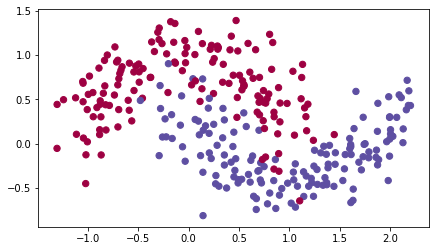

In [19]:
train_X, train_Y = load_dataset()

- Mini-batch **Gradient Descent**: it will call your function:
    - `update_parameters_with_gd()`
- Mini-batch **Momentum**: it will call your functions:
    - `initialize_velocity()` and `update_parameters_with_momentum()`
- Mini-batch **Adam**: it will call your functions:
    - `initialize_adam()` and `update_parameters_with_adam()`

In [20]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

### 5.1 - Mini-batch Gradient descent

Cost after epoch 0: 0.702405
Cost after epoch 1000: 0.668101
Cost after epoch 2000: 0.635288
Cost after epoch 3000: 0.600491
Cost after epoch 4000: 0.573367
Cost after epoch 5000: 0.551977
Cost after epoch 6000: 0.532370
Cost after epoch 7000: 0.514007
Cost after epoch 8000: 0.496472
Cost after epoch 9000: 0.468014


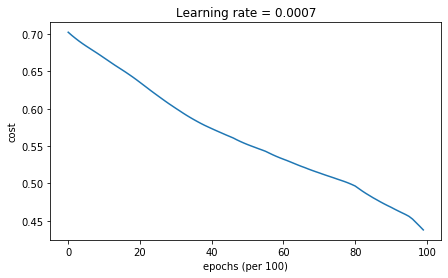

Accuracy: 0.7966666666666666


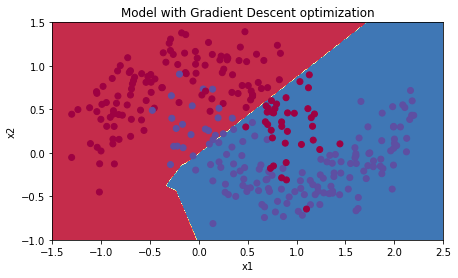

In [22]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y.reshape(train_Y.shape[1]))

### 5.2 - Mini-batch gradient descent with momentum

Cost after epoch 0: 0.702413
Cost after epoch 1000: 0.668167
Cost after epoch 2000: 0.635388
Cost after epoch 3000: 0.600591
Cost after epoch 4000: 0.573444
Cost after epoch 5000: 0.552058
Cost after epoch 6000: 0.532458
Cost after epoch 7000: 0.514101
Cost after epoch 8000: 0.496652
Cost after epoch 9000: 0.468160


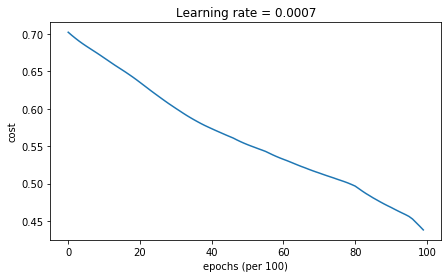

Accuracy: 0.7966666666666666


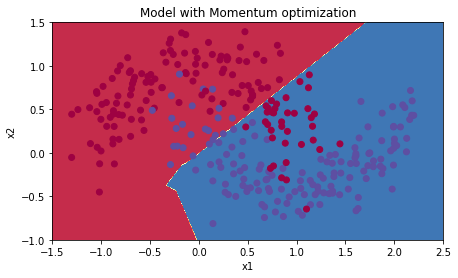

In [23]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y.reshape(train_Y.shape[1]))

Cost after epoch 0: 0.702202
Cost after epoch 1000: 0.394935
Cost after epoch 2000: 0.255727
Cost after epoch 3000: 0.192889
Cost after epoch 4000: 0.161998
Cost after epoch 5000: 0.150044
Cost after epoch 6000: 0.144627
Cost after epoch 7000: 0.141939
Cost after epoch 8000: 0.140491
Cost after epoch 9000: 0.139611


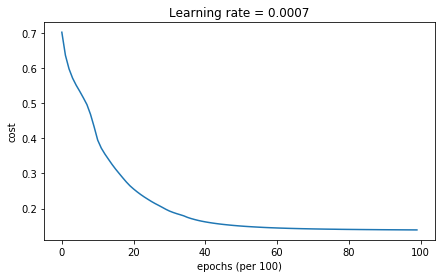

Accuracy: 0.9366666666666666


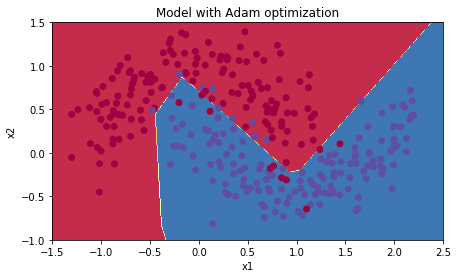

In [24]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y.reshape(train_Y.shape[1]))